In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
import torch
from ogb.nodeproppred import DglNodePropPredDataset

Using backend: pytorch


In [4]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='data/dataset_dgl')
graph = dataset[0][0]

In [5]:
output_emb_file = 'models/deepwalk_05_trvlts_embedding.npy'

In [6]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [7]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [8]:
index.train(embeddings)
index.add(embeddings)

In [9]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f2cc89842a0> >

In [10]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [11]:
distances, indices = index.search(embeddings, 2)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(53615)

In [13]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [14]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [15]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [16]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

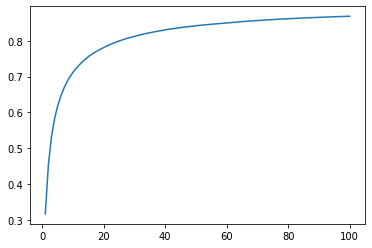

In [17]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [18]:
percentages

tensor([0.3166, 0.4534, 0.5311, 0.5817, 0.6174, 0.6444, 0.6662, 0.6843, 0.6992,
        0.7118, 0.7223, 0.7320, 0.7406, 0.7482, 0.7553, 0.7613, 0.7669, 0.7718,
        0.7764, 0.7809, 0.7852, 0.7891, 0.7927, 0.7959, 0.7990, 0.8020, 0.8048,
        0.8076, 0.8098, 0.8120, 0.8143, 0.8165, 0.8185, 0.8205, 0.8221, 0.8239,
        0.8256, 0.8272, 0.8287, 0.8303, 0.8317, 0.8329, 0.8341, 0.8353, 0.8365,
        0.8376, 0.8387, 0.8396, 0.8406, 0.8417, 0.8426, 0.8435, 0.8443, 0.8451,
        0.8458, 0.8466, 0.8473, 0.8481, 0.8488, 0.8494, 0.8502, 0.8510, 0.8518,
        0.8525, 0.8533, 0.8538, 0.8545, 0.8550, 0.8556, 0.8562, 0.8568, 0.8574,
        0.8579, 0.8585, 0.8590, 0.8596, 0.8600, 0.8604, 0.8609, 0.8613, 0.8617,
        0.8622, 0.8626, 0.8630, 0.8634, 0.8638, 0.8642, 0.8645, 0.8648, 0.8651,
        0.8655, 0.8658, 0.8661, 0.8665, 0.8669, 0.8671, 0.8674, 0.8677, 0.8679,
        0.8682])

In [19]:
percentages.max()

tensor(0.8682)

## Cossine Distance

In [20]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [21]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [22]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [23]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f2be461fe70> >

In [24]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [25]:
distances, indices = index_cos.search(emb_norm, 2)

In [26]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(54006)

In [27]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [28]:
max_k = 100
distances, indices = index.search(emb_norm, max_k + 1)

In [29]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [30]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

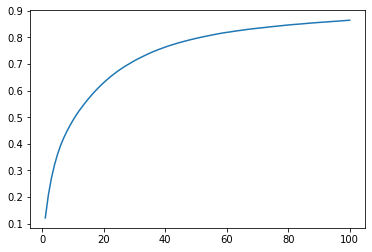

In [31]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [32]:
percentages

tensor([0.1217, 0.2078, 0.2716, 0.3212, 0.3616, 0.3951, 0.4224, 0.4467, 0.4686,
        0.4887, 0.5073, 0.5244, 0.5398, 0.5550, 0.5693, 0.5827, 0.5956, 0.6078,
        0.6194, 0.6303, 0.6406, 0.6504, 0.6598, 0.6687, 0.6768, 0.6848, 0.6922,
        0.6991, 0.7058, 0.7126, 0.7189, 0.7246, 0.7302, 0.7358, 0.7411, 0.7464,
        0.7509, 0.7554, 0.7597, 0.7638, 0.7679, 0.7717, 0.7750, 0.7787, 0.7819,
        0.7850, 0.7881, 0.7910, 0.7939, 0.7965, 0.7991, 0.8018, 0.8041, 0.8064,
        0.8089, 0.8111, 0.8133, 0.8155, 0.8173, 0.8192, 0.8208, 0.8226, 0.8244,
        0.8259, 0.8274, 0.8291, 0.8307, 0.8321, 0.8334, 0.8347, 0.8360, 0.8372,
        0.8384, 0.8398, 0.8411, 0.8422, 0.8434, 0.8446, 0.8458, 0.8469, 0.8480,
        0.8490, 0.8499, 0.8507, 0.8518, 0.8529, 0.8538, 0.8548, 0.8557, 0.8565,
        0.8573, 0.8581, 0.8590, 0.8598, 0.8607, 0.8615, 0.8623, 0.8632, 0.8641,
        0.8648])